In this notebook I try and test different I/O methods to read fits files to load the spectra. I also look a good way to subsample the spectra.

In [10]:
import numpy as np
import fitsio
from fitsio import FITS, FITSHDR
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# Check fitsio was properly installed
fitsio.test.test()

testNonStandardKeyValue (fitsio.test.TestWarnings) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK
testAsciiTableWriteRead (fitsio.test.TestReadWrite) ... ok
testBz2Read (fitsio.test.TestReadWrite) ... ok
testChecksum (fitsio.test.TestReadWrite) ... ok
testExtVer (fitsio.test.TestReadWrite) ... ok
testGZIPTileCompressedWriteRead (fitsio.test.TestReadWrite) ... ok
testGZWriteRead (fitsio.test.TestReadWrite) ... ok
testHCompressTileCompressedWriteRead (fitsio.test.TestReadWrite) ... ok
testHeaderWriteRead (fitsio.test.TestReadWrite) ... ok
testImageSlice (fitsio.test.TestReadWrite) ... ok
testImageWriteRead (fitsio.test.TestReadWrite) ... ok
testImageWriteReadFromDims (fitsio.test.TestReadWrite) ... ok
testImageWriteReadFromDimsChunks (fitsio.test.TestReadWrite) ... ok
testLowerUpper (fitsio.test.TestReadWrite) ... ok
testMoveByName (fitsio.test.TestReadWrite) ... ok
testPLIOTileCompressedWriteRead (fitsio.test.TestReadWrite) ... ok

In [63]:
%%time 
filename = 'data/spectra1000/spec-4216-55477-0204.fits'
data = np.array(Table.read(filename, hdu=1)['loglam','flux'])
# Astropy unified fits io

CPU times: user 84 ms, sys: 15 µs, total: 84 ms
Wall time: 85.7 ms


In [64]:
%%time
filename = 'data/spectra1000/spec-4216-55477-0234.fits'
data = fitsio.read(filename, columns=['loglam','flux'])
# Fitio input utility

CPU times: user 21.2 ms, sys: 25 µs, total: 21.3 ms
Wall time: 21.1 ms


Apparently, the ```fitsio``` library is a little faster. Also, it returns a numpy array directly, rather than a heavy astropy Table

------------------------
Guess: loading the ```loglam``` column is unnecessary because it's always the same array. We need to verify this.

In [48]:
from glob import glob
filelist = glob('data/spectra1000/*.fits')
            
for file in filelist[:10]: # Loop first 10 files
    lam = fitsio.read(file, ext=1, columns='loglam')
    loglams.append(lam.size)
    print(lam.min(), lam.max(), lam.size)

3.5587 4.0168 4582
3.5522 4.0141 4620
3.5521 4.0148 4628
3.5511 4.0145 4635
3.5522 4.0141 4620
3.5597 4.0163 4567
3.5582 4.0165 4584
3.5517 4.0143 4627
3.5574 4.0153 4580
3.5521 4.0139 4619


Clearly, I was wrong. Every file has its own length and the wavelength limits are not the same

Now let's try downsampling the spectrum (because 4000 points would need too much memory and training will be slow)

623 µs ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.5520999431610107 4.0137076809202465


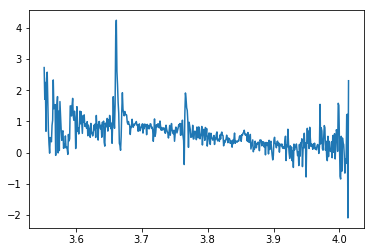

In [84]:
from scipy.signal import resample

data = fitsio.read(filename, ext=1, columns=['loglam','flux'])
# WATCH OUT: The endianness of the arrays must be set to little endian
# before using scipy.signal subsample
loglam = np.asarray(data['loglam'], dtype=np.dtype('<f4'))
flux = np.asarray(data['flux'], dtype=np.dtype('<f4'))

# This is very easy, but behind the scenes is using an
# FFT so I don't know if this will scale reasonably
%timeit sub_flux, sub_loglam = resample(flux, 503, t=loglam)
plt.plot(sub_loglam, sub_flux)
print(sub_loglam.min(), sub_loglam.max())

In [73]:
data['flux'].dtype.byteorder

'>'

In [78]:
import sys
sys.byteorder

'little'